In [51]:
#import packages
import pandas as pd
import numpy as np
import time
import matplotlib as plt
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier



In [52]:
df = pd.read_csv('capture20110810.csv')#'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/detailed-bidirectional-flow-labels/capture20110810.binetflow'

In [53]:
#df.to_csv('capture20110810.csv')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824636 entries, 0 to 2824635
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0.1  int64  
 1   Unnamed: 0    int64  
 2   StartTime     object 
 3   Dur           float64
 4   Proto         object 
 5   SrcAddr       object 
 6   Sport         object 
 7   Dir           object 
 8   DstAddr       object 
 9   Dport         object 
 10  State         object 
 11  sTos          float64
 12  dTos          float64
 13  TotPkts       int64  
 14  TotBytes      int64  
 15  SrcBytes      int64  
 16  Label         object 
dtypes: float64(3), int64(5), object(9)
memory usage: 366.4+ MB


In [55]:
display(df.head(10))

,Unnamed: 0.1,Unnamed: 0,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,0,0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established
1,1,1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
2,2,2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background
3,3,3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,flow=Background
4,4,4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,flow=Background-UDP-Established
5,5,5,2011/08/10 09:46:53.056921,3086.547363,tcp,66.169.184.207,49372,<?>,147.32.84.229,13363,PA_PA,0.0,0.0,591,45931,26480,flow=Background
6,6,6,2011/08/10 09:46:53.058746,3589.631348,udp,182.239.167.121,49649,<->,147.32.84.229,13363,CON,0.0,0.0,12,1494,1122,flow=Background-UDP-Established
7,7,7,2011/08/10 09:46:53.058760,20.360268,tcp,147.32.3.93,443,<?>,147.32.84.59,51790,FPA_FRPA,0.0,0.0,133,81929,67597,flow=Background-Established-cmpgw-CVUT
8,8,8,2011/08/10 09:46:53.062095,3118.470947,udp,24.117.206.20,8697,<->,147.32.84.229,13363,CON,0.0,0.0,13,4328,840,flow=Background-UDP-Established
9,9,9,2011/08/10 09:46:53.068389,1065.003052,tcp,94.208.78.74,50687,<?>,147.32.84.229,13363,FPA_RPA,0.0,0.0,156,14804,7699,flow=Background


# Extract tcp and udp data

In [56]:
df.Proto = df['Proto'].astype("category")

In [57]:
value_counts = df['Proto'].value_counts()
display(value_counts)

Proto
udp          2270083
tcp           507557
icmp           39694
rtp             2570
rtcp            2339
igmp            1803
arp              477
ipv6-icmp         58
ipx/spx           13
esp               10
ipv6              10
udt               10
pim                7
rarp               4
unas               1
Name: count, dtype: int64

In [58]:
value_counts_valid = value_counts[value_counts>=50000].index
value_counts_valid

CategoricalIndex(['udp', 'tcp'], categories=['arp', 'esp', 'icmp', 'igmp', ..., 'tcp', 'udp', 'udt', 'unas'], ordered=False, dtype='category', name='Proto')

In [59]:
df_filtered = df[df['Proto'].isin(value_counts_valid)]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2777640 entries, 0 to 2824635
Data columns (total 17 columns):
 #   Column        Dtype   
---  ------        -----   
 0   Unnamed: 0.1  int64   
 1   Unnamed: 0    int64   
 2   StartTime     object  
 3   Dur           float64 
 4   Proto         category
 5   SrcAddr       object  
 6   Sport         object  
 7   Dir           object  
 8   DstAddr       object  
 9   Dport         object  
 10  State         object  
 11  sTos          float64 
 12  dTos          float64 
 13  TotPkts       int64   
 14  TotBytes      int64   
 15  SrcBytes      int64   
 16  Label         object  
dtypes: category(1), float64(3), int64(5), object(8)
memory usage: 362.9+ MB


# Remove Labels with fewer data samples

In [60]:
df.Label = df['Label'].astype("category")
value_counts_label = df_filtered['Label'].value_counts()
value_counts_label

Label
flow=Background-UDP-Established                                            1164934
flow=To-Background-UDP-CVUT-DNS-Server                                      941706
flow=Background-TCP-Established                                             223543
flow=Background-Established-cmpgw-CVUT                                      137047
flow=Background-TCP-Attempt                                                 105438
                                                                            ...   
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-60                                  1
flow=From-Botnet-V42-TCP-HTTP-Not-Encrypted-Down-2                               1
flow=From-Botnet-V42-TCP-Established-HTTP-Binary-Download-Custom-Port-5          1
flow=From-Botnet-V42-TCP-Established-HTTP-Adobe-4                                1
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-49                                  1
Name: count, Length: 112, dtype: int64

In [61]:
value_counts_label_ids = value_counts_label[value_counts_label>=1000].index
len(value_counts_label_ids)

19

In [62]:
df_filtered = df_filtered[df_filtered['Label'].isin(value_counts_label_ids)]
df_filtered.Label.value_counts()

Label
flow=Background-UDP-Established           1164934
flow=To-Background-UDP-CVUT-DNS-Server     941706
flow=Background-TCP-Established            223543
flow=Background-Established-cmpgw-CVUT     137047
flow=Background-TCP-Attempt                105438
flow=Background-UDP-Attempt                 66616
flow=From-Botnet-V42-UDP-DNS                26140
flow=Background-Attempt-cmpgw-CVUT          20952
flow=To-Background-CVUT-Proxy               19524
flow=From-Normal-V42-Stribrek               18438
flow=Background                              9136
flow=From-Botnet-V42-TCP-Attempt-SPAM        8105
flow=From-Normal-V42-Grill                   7620
flow=From-Normal-V42-Jist                    3807
flow=From-Botnet-V42-UDP-Attempt-DNS         3057
flow=To-Background-CVUT-WebServer            2550
flow=Background-UDP-NTP-Established-1        2233
flow=From-Botnet-V42-TCP-Attempt             1881
flow=Background-ajax.google                  1197
Name: count, dtype: int64

In [63]:
benign_categories = ['flow=Background-UDP-Established', 'flow=To-Background-UDP-CVUT-DNS-Server', 'flow=Background-TCP-Established', 'flow=Background-Established-cmpgw-CVUT', 'flow=Background-TCP-Attempt', 'flow=Background-UDP-Attempt', 'flow=Background-Attempt-cmpgw-CVUT', 'flow=To-Background-CVUT-Proxy', 'flow=From-Normal-V42-Stribrek', 'flow=Background', 'flow=From-Normal-V42-Grill', 'flow=From-Normal-V42-Jist', 'flow=From-Botnet-V42-UDP-Attempt-DNS', 'flow=To-Background-CVUT-WebServer', 'flow=Background-UDP-NTP-Established-1', 'flow=Background-ajax.google']
malware_categories = ['flow=From-Botnet-V42-UDP-DNS', 'flow=From-Botnet-V42-TCP-Attempt-SPAM', 'flow=From-Botnet-V42-TCP-Attempt']
category_mapping = {cat: 0 for cat in benign_categories}
category_mapping.update({cat: 1 for cat in malware_categories})

In [64]:
df_filtered.Label = df['Label'].map(category_mapping)
print(df_filtered.Label.value_counts())
df_filtered.head()

Label
0.0    2727798
1.0      36126
Name: count, dtype: int64


,Unnamed: 0.1,Unnamed: 0,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,0,0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,0.0
1,1,1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,0.0
2,2,2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,0.0
3,3,3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,0.0
4,4,4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,0.0


In [65]:
df.dTos.sum()

np.float64(1165.0)

In [66]:
#df_filtered = df_filtered.drop(['Dir', 'StartTime', 'State', 'SrcAddr', 'DstAddr'], axis=1)

In [67]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2763924 entries, 0 to 2824635
Data columns (total 17 columns):
 #   Column        Dtype   
---  ------        -----   
 0   Unnamed: 0.1  int64   
 1   Unnamed: 0    int64   
 2   StartTime     object  
 3   Dur           float64 
 4   Proto         category
 5   SrcAddr       object  
 6   Sport         object  
 7   Dir           object  
 8   DstAddr       object  
 9   Dport         object  
 10  State         object  
 11  sTos          float64 
 12  dTos          float64 
 13  TotPkts       int64   
 14  TotBytes      int64   
 15  SrcBytes      int64   
 16  Label         float64 
dtypes: category(1), float64(4), int64(5), object(7)
memory usage: 361.1+ MB


In [68]:
# reset the index
df_filtered = df_filtered.reset_index()
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763924 entries, 0 to 2763923
Data columns (total 18 columns):
 #   Column        Dtype   
---  ------        -----   
 0   index         int64   
 1   Unnamed: 0.1  int64   
 2   Unnamed: 0    int64   
 3   StartTime     object  
 4   Dur           float64 
 5   Proto         category
 6   SrcAddr       object  
 7   Sport         object  
 8   Dir           object  
 9   DstAddr       object  
 10  Dport         object  
 11  State         object  
 12  sTos          float64 
 13  dTos          float64 
 14  TotPkts       int64   
 15  TotBytes      int64   
 16  SrcBytes      int64   
 17  Label         float64 
dtypes: category(1), float64(4), int64(6), object(7)
memory usage: 361.1+ MB


In [69]:
# drop rows with NaN values for Sport and Dport
df_filtered = df_filtered.dropna(subset=['Sport', 'Dport'])
print(df_filtered['Sport'].isna().sum())
df_filtered['Dport'].isna().sum()


0


np.int64(0)

In [70]:
df_filtered.Sport = df_filtered.Sport.astype('int64')
df_filtered.Dport = df_filtered.Dport.astype('int64')

In [71]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2763439 entries, 0 to 2763923
Data columns (total 18 columns):
 #   Column        Dtype   
---  ------        -----   
 0   index         int64   
 1   Unnamed: 0.1  int64   
 2   Unnamed: 0    int64   
 3   StartTime     object  
 4   Dur           float64 
 5   Proto         category
 6   SrcAddr       object  
 7   Sport         int64   
 8   Dir           object  
 9   DstAddr       object  
 10  Dport         int64   
 11  State         object  
 12  sTos          float64 
 13  dTos          float64 
 14  TotPkts       int64   
 15  TotBytes      int64   
 16  SrcBytes      int64   
 17  Label         float64 
dtypes: category(1), float64(4), int64(8), object(5)
memory usage: 382.1+ MB


# Copy required columns to a new DataFrame

In [72]:
df_final = df_filtered[['Dur', 'Proto', 'Sport', 'Dport', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes', 'Label']].copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2763439 entries, 0 to 2763923
Data columns (total 10 columns):
 #   Column    Dtype   
---  ------    -----   
 0   Dur       float64 
 1   Proto     category
 2   Sport     int64   
 3   Dport     int64   
 4   sTos      float64 
 5   dTos      float64 
 6   TotPkts   int64   
 7   TotBytes  int64   
 8   SrcBytes  int64   
 9   Label     float64 
dtypes: category(1), float64(4), int64(5)
memory usage: 213.5 MB


# split the dataset into TCP and UDP

In [73]:
df_tcp = df_final[df_filtered.Proto.isin(['tcp'])]
df_tcp = df_tcp.reset_index()
df_tcp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493891 entries, 0 to 493890
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   index     493891 non-null  int64   
 1   Dur       493891 non-null  float64 
 2   Proto     493891 non-null  category
 3   Sport     493891 non-null  int64   
 4   Dport     493891 non-null  int64   
 5   sTos      490900 non-null  float64 
 6   dTos      417637 non-null  float64 
 7   TotPkts   493891 non-null  int64   
 8   TotBytes  493891 non-null  int64   
 9   SrcBytes  493891 non-null  int64   
 10  Label     493891 non-null  float64 
dtypes: category(1), float64(4), int64(6)
memory usage: 38.2 MB


In [74]:
df_udp = df_final[df_filtered.Proto.isin(['udp'])]
df_udp = df_udp.reset_index()
df_udp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269548 entries, 0 to 2269547
Data columns (total 11 columns):
 #   Column    Dtype   
---  ------    -----   
 0   index     int64   
 1   Dur       float64 
 2   Proto     category
 3   Sport     int64   
 4   Dport     int64   
 5   sTos      float64 
 6   dTos      float64 
 7   TotPkts   int64   
 8   TotBytes  int64   
 9   SrcBytes  int64   
 10  Label     float64 
dtypes: category(1), float64(4), int64(6)
memory usage: 175.3 MB


In [75]:
display(df_tcp.Label.value_counts())
display(df_udp.Label.value_counts())

Label
0.0    483905
1.0      9986
Name: count, dtype: int64

Label
0.0    2243408
1.0      26140
Name: count, dtype: int64

In [76]:
df_tcp.drop(columns=['index'], inplace=True)
df_udp.drop(columns=['index'], inplace=True)

In [77]:
df_tcp.info()
df_tcp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493891 entries, 0 to 493890
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   Dur       493891 non-null  float64 
 1   Proto     493891 non-null  category
 2   Sport     493891 non-null  int64   
 3   Dport     493891 non-null  int64   
 4   sTos      490900 non-null  float64 
 5   dTos      417637 non-null  float64 
 6   TotPkts   493891 non-null  int64   
 7   TotBytes  493891 non-null  int64   
 8   SrcBytes  493891 non-null  int64   
 9   Label     493891 non-null  float64 
dtypes: category(1), float64(4), int64(5)
memory usage: 34.4 MB


,Dur,Proto,Sport,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,0.000326,tcp,80,2063,0.0,0.0,2,120,60,0.0
1,0.056966,tcp,32882,21857,0.0,0.0,3,180,120,0.0
2,3086.547363,tcp,49372,13363,0.0,0.0,591,45931,26480,0.0
3,20.360268,tcp,443,51790,0.0,0.0,133,81929,67597,0.0
4,1065.003052,tcp,50687,13363,0.0,0.0,156,14804,7699,0.0


# Training only on TCP

In [78]:
#Separate input and target columns for TCP
df_tcp_input = df_tcp.drop(columns=['Label', 'Proto']).copy()
df_tcp_target = df_tcp['Label'].copy()
print(df_tcp_input.info())
print(df_tcp_target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493891 entries, 0 to 493890
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Dur       493891 non-null  float64
 1   Sport     493891 non-null  int64  
 2   Dport     493891 non-null  int64  
 3   sTos      490900 non-null  float64
 4   dTos      417637 non-null  float64
 5   TotPkts   493891 non-null  int64  
 6   TotBytes  493891 non-null  int64  
 7   SrcBytes  493891 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 30.1 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 493891 entries, 0 to 493890
Series name: Label
Non-Null Count   Dtype  
--------------   -----  
493891 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB
None


In [79]:
X_train, X_test, y_train, y_test = train_test_split(df_tcp_input, df_tcp_target, test_size=0.2, random_state=42, shuffle=True)
clf_sgd = SGDClassifier(random_state=42)

In [80]:
pipe = make_pipeline(SimpleImputer(strategy='mean'), preprocessing.StandardScaler() )
X_train_scaled = pipe.fit_transform(X_train)
X_test_scaled = pipe.fit_transform(X_test)

In [81]:
clf_sgd.fit(X_train_scaled,y_train)

SGDClassifier(random_state=42)

In [82]:
y_preds_sgd = clf_sgd.predict(X_test_scaled)

In [83]:
y_preds_sgd

array([0., 0., 0., ..., 0., 0., 0.])

In [85]:
result = accuracy_score(y_preds_sgd, y_test)
result

0.9797932758987234

In [86]:
clf_rfc = RandomForestClassifier(random_state=42)
clf_rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [87]:
y_preds_rfc = clf_rfc.predict(X_test_scaled)
result = accuracy_score(y_preds_rfc, y_test)
result

0.9797932758987234

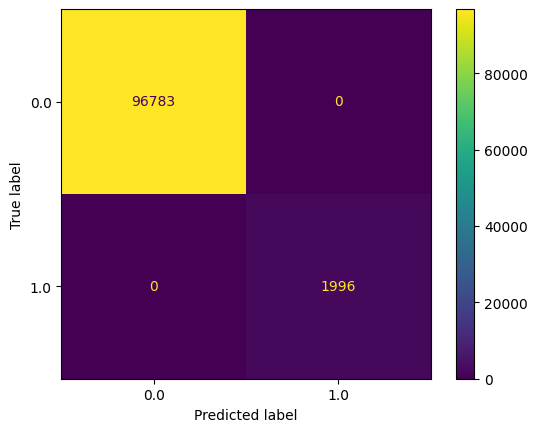

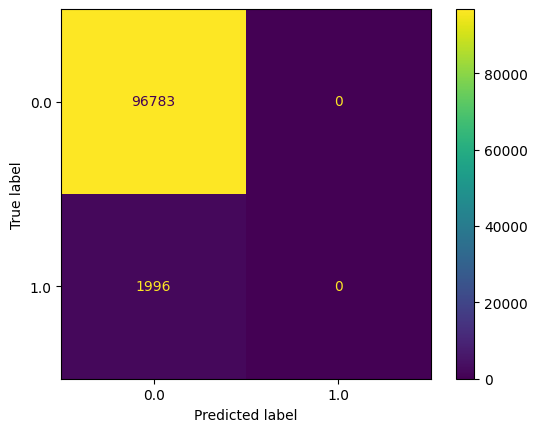

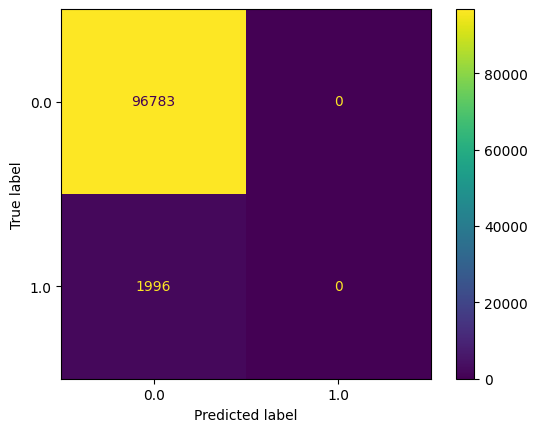

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_ideal = confusion_matrix(y_test, y_test, labels=clf_rfc.classes_)
cm_sdg = confusion_matrix(y_test, y_preds_sgd, labels=clf_rfc.classes_)
cm_rcf = confusion_matrix(y_test, y_preds_rfc, labels=clf_rfc.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_ideal, display_labels=clf_rfc.classes_).plot()
ConfusionMatrixDisplay(confusion_matrix=cm_sdg, display_labels=clf_sgd.classes_).plot()
ConfusionMatrixDisplay(confusion_matrix=cm_rcf, display_labels=clf_rfc.classes_).plot()

**Observations:**
The first image plots the confusion matrix for ideal scenario, where you want zeros on either side of the diagonal and want the labels to classified 100% correctly. But In machine learning this is difficult.

The second and third images show that the model is heavily biased to predict label '0' all the time. Possible reasons:
- Imbalance in the observations: observations/samples for label '1' are significantly lower compared to that of label '0'.
- Non representative features: Even though we have removed some of non numerical features, the remaining features are not representative.

# Using deep learning

In [89]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

tf.random.set_seed(42)

# Step 3: Define a Deep Learning Model Architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with an optimized loss function and optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 4: Implement Callbacks for Optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Step 5: Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

Epoch 1/100


/opt/anaconda3/envs/ml_basic/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4939/4939 - 5s - 975us/step - accuracy: 0.9794 - loss: 0.0638 - val_accuracy: 0.9788 - val_loss: 0.0874 - learning_rate: 1.0000e-03
Epoch 2/100
4939/4939 - 4s - 780us/step - accuracy: 0.9923 - loss: 0.0220 - val_accuracy: 0.9863 - val_loss: 0.0253 - learning_rate: 1.0000e-03
Epoch 3/100
4939/4939 - 4s - 782us/step - accuracy: 0.9933 - loss: 0.0194 - val_accuracy: 0.9923 - val_loss: 0.0200 - learning_rate: 1.0000e-03
Epoch 4/100
4939/4939 - 4s - 766us/step - accuracy: 0.9934 - loss: 0.0187 - val_accuracy: 0.9937 - val_loss: 0.0172 - learning_rate: 1.0000e-03
Epoch 5/100
4939/4939 - 4s - 779us/step - accuracy: 0.9935 - loss: 0.0187 - val_accuracy: 0.9942 - val_loss: 0.0163 - learning_rate: 1.0000e-03
Epoch 6/100
4939/4939 - 4s - 785us/step - accuracy: 0.9936 - loss: 0.0182 - val_accuracy: 0.9921 - val_loss: 0.0197 - learning_rate: 1.0000e-03
Epoch 7/100
4939/4939 - 4s - 806us/step - accuracy: 0.9941 - loss: 0.0172 - val_accuracy: 0.9939 - val_loss: 0.0198 - learning_rate: 1.0000e-03
Epoc

3087/3087 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     96783
         1.0       0.91      0.89      0.90      1996

    accuracy                           1.00     98779
   macro avg       0.96      0.94      0.95     98779
weighted avg       1.00      1.00      1.00     98779



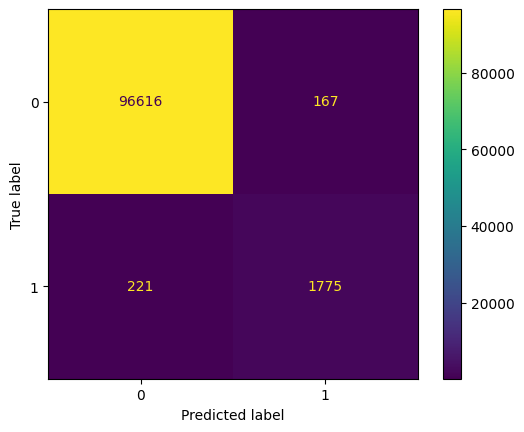

In [ ]:
#Step 6: Evaluate the model
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
cm_mlp = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_mlp).plot()
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

**Observations:**

In spite of drawbacks in the dataset, that are clearly visible in the SGD classifier and RF classifier performance, MLP classifier did a fantastic job using the limited features. This is one of the strong advantage of neural networks.